In [1]:
import os
import glob

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

import importlib

import plotting as putil
import utils as util
import tifffile as tf

In [2]:
import cv2
import matplotlib.gridspec as gridspec


In [3]:
putil.set_sns_style()

In [4]:
%matplotlib inline

In [59]:
rootdir = '/mnt/minerva/2p-data'
session = 20230822 #20230725
flyid = 'fly3'
run_index = 1
# ------------------------------------------------------------
# neural data (2p tifs are combined then split into Ch2)
sessiondir = os.path.join(rootdir, str(session))
all_neural_fpaths = sorted(glob.glob(os.path.join(sessiondir, 
                                'raw', '{}*{}*_Ch2.tif'.format(str(session), flyid))), key=util.natsort)
neural_fpath = all_neural_fpaths[run_index]
print(neural_fpath)
assert os.path.exists(neural_fpath), "2p path does not exist: {}".format(neural_fpath)
# ------------------------------------------------------------
# face cam video paths
# NOTE: .mp4 is compressed, prob easier to work with
# NOTE2: sometimes, >1 video...
all_vid_fpaths = sorted(glob.glob(os.path.join(sessiondir, 
                                'behavior', '{}*{}'.format(str(session), flyid))), key=util.natsort)
vid_dir = all_vid_fpaths[run_index]
vid_fn = os.path.split(vid_dir)[-1]
vid_fpath = glob.glob(os.path.join(sessiondir, 'behavior', vid_fn, '*.mp4'))[0]
assert os.path.exists(vid_fpath), "Vid path does not exist: {}".format(vid_fpath)
print(vid_fpath)
#---
# logfiles
logdf_fn = '{}-{}'.format(str(session), flyid)
log_fpath = glob.glob(os.path.join(rootdir, str(session), 'processed', '{}.pkl'.format(logdf_fn)))[0]
assert(os.path.exists(log_fpath)), "Dataframe file for log does not exist: {}".format(log_fpath)
print(log_fpath)

/mnt/minerva/2p-data/20230822/raw/20230822-1535_fly3-001_Ch2.tif
/mnt/minerva/2p-data/20230822/behavior/20230822-160623_fly3/flyleft_20230822160623_00000.mp4
/mnt/minerva/2p-data/20230822/processed/20230822-fly3.pkl


In [52]:
# rootdir = '/mnt/minerva/2p-data'
# session = 20230822 #20230725
# flyid = 'fly3'
# # -------------------------------------------
# # some hard-coded paths for now
# neural_fn = '20230725-1620_fly3-005_Ch2.tif'
# neural_fpath = os.path.join(rootdir, str(session), 'raw', neural_fn)
# assert os.path.exists(neural_fpath), "2p path does not exist: {}".format(neural_fpath)

# # vid_fn = '20230725-172433_fly3'
# vid_fpath = glob.glob(os.path.join(rootdir, str(session), 'behavior', 'videos', vid_fn, '*0.avi'))[0]
# vid_fn= '20230822-1535_fly3'
# vid_fpath = glob.glob(os.path.join(rootdir, str(session), 'behavior', 'videos', vid_fn, '*.avi'))[0]
# assert os.path.exists(vid_fpath), "Vid path does not exist: {}".format(vid_fpath)

# logdf_fn = '{}-{}'.format(str(session), flyid)
# logdf_fpath = glob.glob(os.path.join(rootdir, str(session), 'processed', '{}.pkl'.format(logdf_fn)))[0]
# assert(os.path.exists(log_fpath)), "Dataframe file for log does not exist: {}".format(logdf_fpath)

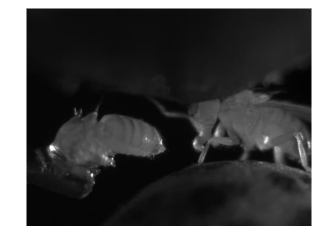

In [53]:
# FACECAM video
start_frame=0
vcap = cv2.VideoCapture(vid_fpath)
vcap.set(1, start_frame)
ret, frame = vcap.read()

fig, ax = pl.subplots()
ax.imshow(frame)

In [54]:
# 2p stack
neuralstack = tf.imread(neural_fpath)
neuralstack.shape

(6000, 106, 23)

(6000, 23, 106)


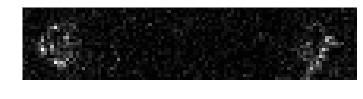

In [55]:
rotated_stack = np.rot90(neuralstack, k = 1, axes = (1, 2)) # transpose and flip the 2 axes, with 1st tagging along
print(rotated_stack.shape)

fig, ax = pl.subplots()
ax.imshow(rotated_stack[0, :, :], cmap='gray')

In [56]:
rotated_stack.shape

(6000, 23, 106)

## neural traces

In [103]:
traces_fns = glob.glob(os.path.join(rootdir, str(session), 'processed', '*H.csv')) # manually extracted
d_list=[]
for fn in traces_fns:
    df_ = pd.read_csv(fn)
    if 'LH' in fn:
        df_['hemi'] = 'left'
    else:
        df_['hemi'] = 'right'
    d_list.append(df_)
traces = pd.concat(d_list, axis=0)

In [104]:
nframes_neural = 6000
fps_neural = 10
fps_sidecam = 120

traces['time'] = traces['Slice']/fps_neural
traces.head()

,Slice,Mean,hemi,time
0,1,77.5956,left,0.1
1,2,79.4044,left,0.2
2,3,76.3860,left,0.3
3,4,80.2243,left,0.4
4,5,80.0993,left,0.5


In [142]:
traces.tail()

,Slice,Mean,hemi,time
5995,5996,80.7941,right,599.6
5996,5997,82.2279,right,599.7
5997,5998,80.5699,right,599.8
5998,5999,83.0441,right,599.9
5999,6000,82.3713,right,600.0


In [118]:
def subtract_rolling_mean(trace, windowsz):
    #print(trace.shape)
    tmp1 = np.concatenate((np.ones(windowsz)*trace.values[0], trace, np.ones(windowsz)*trace.values[-1]),0)
    rolling_mean = np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    rolling_mean=rolling_mean[windowsz:-windowsz]
    return np.subtract(trace, rolling_mean)


In [280]:
for hemi, df_ in traces.groupby('hemi'):
    t = df_['Mean'].copy()
    t_sub = subtract_rolling_mean(t, 500)
    traces.loc[df_.index, 'Mean_detrended'] = t_sub
    traces.loc[df_.index, 'Mean_basesub'] = df_['Mean'] - df_['Mean'].mean()

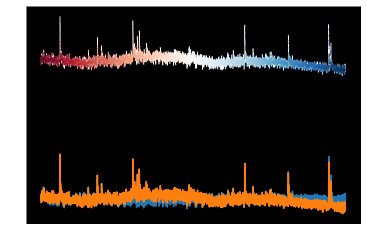

In [312]:
t = traces[traces['hemi']=='right']['Mean'].copy()
t_sub = subtract_rolling_mean(t, 500)
fig, ax= pl.subplots()
# ax.plot(t-t[0])
# ax.plot(t_sub)
ax.plot(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='right']['Mean'], lw=0.5, color='w', zorder=0)
ax.scatter(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='right']['Mean'], c=pos_colors, s=.1, zorder=500)

ax.plot(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='right']['Mean_detrended'])
ax.plot(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='right']['Mean_basesub'])


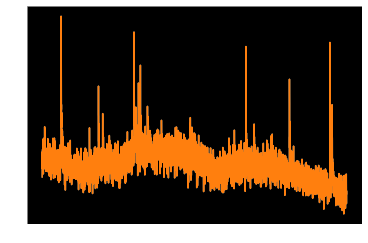

In [493]:
fig, ax= pl.subplots()
ax.plot(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='right']['Mean_basesub'])
ax.plot(traces[traces['hemi']=='left']['time'], traces[traces['hemi']=='left']['Mean_basesub'])


In [287]:
len(pos_colors), len(t_sub)

(6000, 6000)

In [113]:
 traces[traces['hemi']=='right']['Mean'].iloc[0]

85.6654

## downsample facecam vid to 20Hz

In [196]:
create_new = True
# ds_indices = np.arange(0, 72006, 6)
nframes_sidecam = fps_sidecam * 60 * 10 + (fps_sidecam/fps_neural)
ds_indices = np.arange(0, nframes_sidecam, fps_sidecam/fps_neural)
# neural 10hz, behavior vid, 120Hz
# ---------------------------------------------------------------------------------
vid_fname = os.path.split(vid_fpath)[-1]
ds_vid_fpath = os.path.join(rootdir, str(session), 'processed', vid_fname.replace('0.avi', '0_ds-20Hz.avi'))
    
if not os.path.exists(ds_vid_fpath):
    create_new=True
    print("Creating new")
    
if create_new:
    # neural sampled at 20Hz, face cam sampled at 120Hz
    # downsample facecam?
    print(ds_vid_fpath)

    vcap = cv2.VideoCapture(vid_fpath)
    #fourcc = cv2.VideoWriter_fourcc('F', 'M', 'P', '4')
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(ds_vid_fpath, fourcc, fps_neural, (504, 384)) #(int(vcap.get(3)), int(vcap.get(4)))) #frame.shape[1], frame.shape[0]))
    try:
        for i in ds_indices: #np.arange(0, 72006, 6):
            vcap.set(1, i)
            ret, frame = vcap.read(cv2.IMREAD_UNCHANGED)
            #frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            if i%10000==0:
                print(i, frame.shape)
            out.write(frame)
    except Exeption as e:
        print(e)
    finally:
        vcap.release()
        out.release()
    create_new = False
else:
    assert os.path.exists(ds_vid_fpath), 'VIDEO DOES NOT EXIST: {}'.format(ds_vid_fpath)

/mnt/minerva/2p-data/20230822/processed/flyleft_20230822160623_00000.mp4
0.0 (384, 504, 3)
30000.0 (384, 504, 3)
60000.0 (384, 504, 3)


In [107]:
import _pickle as pkl

In [108]:
# with open(log_fpath, 'rb') as f:
#     logdf = pkl.load(f)
logdf = pd.read_csv(log_fpath.replace('.pkl', '.csv'))
logdf.head()
# logdf = pd.read_pickle(log_fpath)


,Unnamed: 0,index,timestamp -- motor_step_command,mfc1_stpt,mfc2_stpt,mfc3_stpt,led1_stpt,led2_stpt,sig_status,ft_posx,...,blocknum,boutnum,cum_time,speed,upwind_speed,crosswind_speed,euclid_dist,upwind_dist,crosswind_dist,flyid
0,0,1.0,08/22/2023-15:38:12.785697 -- 799968,0.0,0.0,0.0,0.0,0.0,0.0,-0.366433,...,0.0,1,0.000000,9.304608,8.254097,-4.294836,0.000000,0.000000,0.000000,fly3
1,1,2.0,08/22/2023-15:38:12.796002 -- 799968,0.0,0.0,0.0,0.0,0.0,0.0,-0.410691,...,0.0,1,0.010305,4.613195,4.429341,-1.289381,0.095883,0.085058,0.044258,fly3
2,2,3.0,08/22/2023-15:38:12.813381 -- 799967,0.0,0.0,0.0,0.0,0.0,0.0,-0.402128,...,0.0,1,0.037989,3.372304,3.199446,-1.065823,0.038527,0.037564,0.008563,fly3
3,3,4.0,08/22/2023-15:38:12.829238 -- 799968,0.0,0.0,0.0,0.0,0.0,0.0,-0.446115,...,0.0,1,0.081530,5.149950,4.425511,-2.633788,0.081637,0.068773,0.043986,fly3
4,4,5.0,08/22/2023-15:38:12.845660 -- 799967,0.0,0.0,0.0,0.0,0.0,0.0,-0.487144,...,0.0,1,0.141493,1.748834,1.206733,-1.265786,0.084682,0.074078,0.041030,fly3


In [109]:
filenames = sorted(logdf['filename'].unique(), key=util.natsort)
filenames

['20230822-153812_P1_activation_fly3_000',
 '20230822-160657_P1_activation_fly3_001',
 '20230822-162257_P1_activation_fly3_002',
 '20230822-162500_P1_activation_fly3_003',
 '20230822-163923_P1_activation_fly3_004']

In [270]:
traces[traces['hemi']=='left']['time'].iloc[1715]

171.6

In [163]:
tsec_2p = traces[traces['hemi']=='left']['time'].values
tsec_logdf = currlogdf['rel_time']
xpos_logdf = currlogdf['ft_posx']
ypos_logdf = currlogdf['ft_posy']

xpos_interp = np.interp(tsec_2p, tsec_logdf, xpos_logdf)
ypos_interp = np.interp(tsec_2p, tsec_logdf, ypos_logdf)

20230822-160657_P1_activation_fly3_001


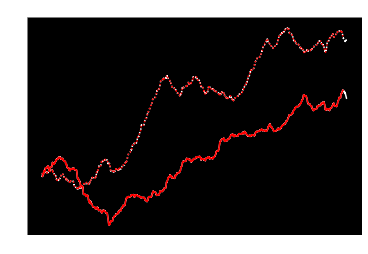

In [164]:
fn = filenames[run_index]
print(fn)
currlogdf = logdf[logdf['filename']==fn].copy().reset_index()
# 
fig, ax = pl.subplots()
ax.plot(currlogdf['rel_time'], currlogdf['ft_posx'], 'w')
ax.plot(currlogdf['rel_time'], currlogdf['ft_posy'], color='w', linestyle=':')

ax.plot(tsec_2p, xpos_interp, 'r')
ax.plot(tsec_2p, ypos_interp, 'r', linestyle=':')

ax.set_title('X and Y pos, after merge')
pl.subplots_adjust(hspace=0.5)


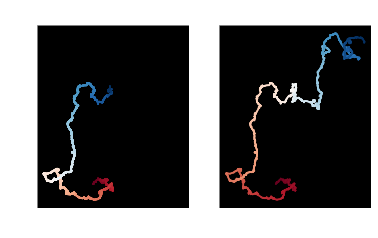

In [286]:
fig, axn = pl.subplots(1, 2, sharex=True, sharey=True)
xvar='ft_posx'
yvar='ft_posy'
dur_min = df1_['rel_time'].max() / 60.
ax=axn[0]
sns.scatterplot(data=df1_[df1_['rel_time']<=300], x=xvar, y=yvar, ax=ax, palette='RdBu',
               edgecolor='none', s=3 , legend=0, hue='rel_time') #color=colors[ci])
                #hue_norm=mpl.colors.Normalize(vmin=0, vmax=1800))
curr_cond = df1_['condition'].unique()[0]
ax.set_title('{} ({:.2f} min)\n{}'.format(curr_cond, dur_min, \
                                              fn.split('_')[-1]))
ax=axn[1]
pos_colors = sns.color_palette('RdBu', n_colors=len(xpos_interp))
sns.scatterplot(x=xpos_interp, y=ypos_interp, ax=ax, c=pos_colors,# palette='RdBu',
               edgecolor='none', s=3 , legend=0)
ax.set_title('interp. to 2p sampling rate')
for ax in axn:
    ax.set_aspect('equal')

In [381]:
pos_colors = np.array(sns.color_palette('RdBu', n_colors=len(xpos_interp)))
pos_colors

array([[0.40392157, 0.        , 0.12156863],
       [0.40392157, 0.        , 0.12156863],
       [0.40392157, 0.        , 0.12156863],
       ...,
       [0.01960784, 0.18823529, 0.38039216],
       [0.01960784, 0.18823529, 0.38039216],
       [0.01960784, 0.18823529, 0.38039216]])

# make gif

In [166]:
from matplotlib import animation, rc

In [436]:
ds_vid_fpath 
vcap = cv2.VideoCapture(ds_vid_fpath)
i = 100
vcap.set(1, i)
ret, frame = vcap.read(cv2.IMREAD_UNCHANGED)
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

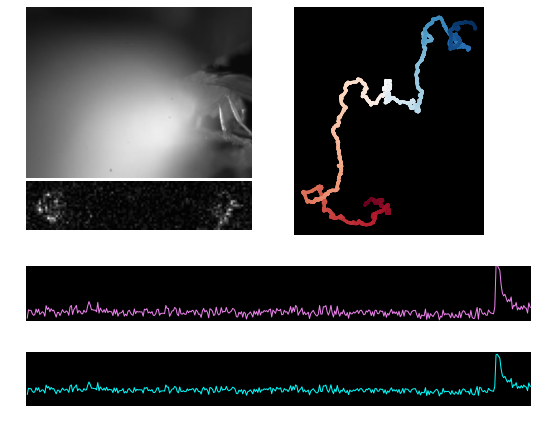

In [485]:
fig = pl.figure(figsize=(10,6), constrained_layout=True)

spec = gridspec.GridSpec(ncols=8, nrows=5, figure=fig)
ax0 = fig.add_subplot(spec[0:3, 0:3]) # video
ax1 = fig.add_subplot(spec[2:, 0:3])  # 2p
ax2 = fig.add_subplot(spec[3, 0:6]) #, sharex=ax2)  # RH
ax2b = fig.add_subplot(spec[4, 0:6], sharex=ax2) #, sharex=ax2)  # RH
ax3 = fig.add_subplot(spec[0:3, 3:])  # LH
# images
ax0.imshow(frame, cmap='gray'); ax0.axis('off')
ax0.set_anchor('N')
ax1.imshow(rotated_stack[0, :, :], cmap='gray'); ax1.axis('off')
ax1.set_anchor('N')
# 2p traces
ax2.set_xlim([0, traces[traces['hemi']=='left'].loc[:end_frame]['time'].max()])
ymax = max([np.ceil(traces[traces['hemi']=='left'].loc[:end_frame]['Mean_detrended'].max()), 
            np.ceil(traces[traces['hemi']=='right'].loc[:end_frame]['Mean_detrended'].max())])
ymin = max([np.ceil(traces[traces['hemi']=='left'].loc[:end_frame]['Mean_detrended'].min()), 
            np.ceil(traces[traces['hemi']=='right'].loc[:end_frame]['Mean_detrended'].min())])
ax2.set_ylim([ymin, ymax])

ax2.plot(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='left']['Mean_basesub'], lw=1, color='violet', zorder=0)
#ax2.scatter(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='left']['Mean_basesub'], c=pos_colors, s=.25, zorder=500)
ax2b.plot(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='right']['Mean_basesub'], lw=1, color='aqua', zorder=0)
#ax2b.scatter(traces[traces['hemi']=='right']['time'], traces[traces['hemi']=='right']['Mean_basesub'], c=pos_colors, s=.25, zorder=500)
ax2.set_anchor('N')
ax2b.set_anchor('N')
ax2b.set_xlabel('time (s)')
# Trajectory
ax3.scatter(xpos_interp, ypos_interp, c=pos_colors, s=5)
ax3.set_aspect('equal')
ax3.set_anchor('W')
sns.despine(offset=4, trim=True)
# sns.despine(trim=True, offset={'left': 0, 'bottom': 10})

In [243]:
traces['time'].max()

600.0

In [472]:
destdir = os.path.join(rootdir, str(session), 'processed')

tsec_2p = traces[traces['hemi']=='left']['time'].values
rawL = traces[traces['hemi']=='left']['Mean_basesub'].values
rawR = traces[traces['hemi']=='right']['Mean_basesub'].values

In [277]:
tsec[250], tsec[3000]

(25.1, 300.1)

In [456]:
start_frame

300

In [469]:
# vcap = cv2.VideoCapture(ds_vid_fpath)
# vcap.set(1, 300)
# ret, frame = vcap.read(cv2.IMREAD_UNCHANGED)
# nx, ny, _ = frame.shape
# frame_ixs = list(range(start_frame, end_frame))

# for i in range(len(frame_ixs)):
#     vcap.set(1, frame_ixs[i])
#     ret, frame = vcap.read()
#     print(frame_ixs[i], frame.shape)
# vcap.release()

In [473]:
i = 5
#xy = np.array([[i, j] for i, j in zip(tsec[:frame_ixs[i]], rawR[:frame_ixs[i]])])

xycoords = np.array([[i, j] for i, j in zip(xpos_interp, ypos_interp)])
xyR = np.array([[i, j] for i, j in zip(tsec[:frame_ixs[i]], rawR[:frame_ixs[i]])])
xyL = np.array([[i, j] for i, j in zip(tsec[:frame_ixs[i]], rawL[:frame_ixs[i]])])

In [459]:
len(pos_colors)

6000

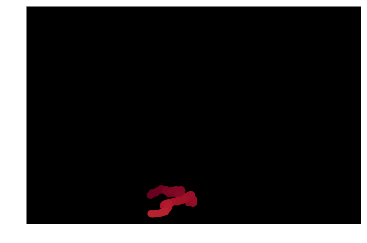

In [460]:
# # Set playblack
# start_frame=0 #180 #0
# end_frame=1000 #580 #100
# frame_ixs = list(range(start_frame, end_frame))

# fig, ax= pl.subplots()
# p1 = ax.scatter(xpos_interp, ypos_interp, c=tsec, cmap='RdBu')
# p1.set_offsets(xycoords[:frame_ixs[700]]) 
# p1.set_array(tsec[:frame_ixs[700]]) 


In [467]:
vcap.release()

In [491]:
rotated_stack.shape

(6000, 23, 106)

300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
/mnt/minerva/2p-data/20230822/processed/example-taps-traj-half1-slow.mp4


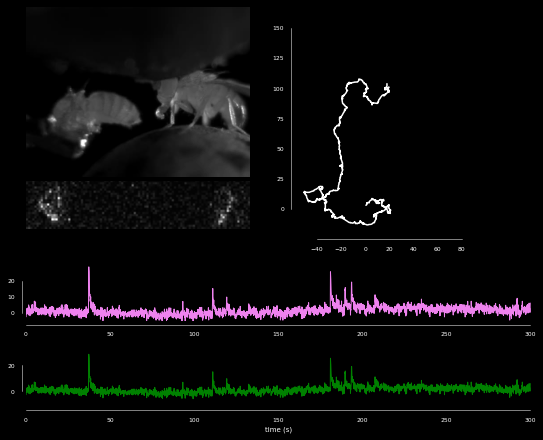

In [494]:
# Set playblack
video_rate=10.
start_frame=300 #180 #0
end_frame=3000 #580 #100
i = 0
frame_ixs = list(range(start_frame, end_frame))

nframes =  len(frame_ixs) #start_frame
interval = (1./video_rate) * 1E3

# FACECAM video
vcap = cv2.VideoCapture(ds_vid_fpath)
vcap.set(1, start_frame)
ret, frame = vcap.read(cv2.IMREAD_UNCHANGED)
nx, ny, _ = frame.shape

# NEURAL DATA
neural_frame = rotated_stack[start_frame, :, :]
_, nx_neural, ny_neural = rotated_stack.shape
# ------------------------------------
fig = pl.figure(figsize=(10,6), constrained_layout=True)
fig.patch.set_facecolor('k') #fig.patch.set_alpha(0)

spec = gridspec.GridSpec(ncols=8, nrows=5, figure=fig)
ax0 = fig.add_subplot(spec[0:3, 0:3]) # video
ax1 = fig.add_subplot(spec[2:, 0:3])  # 2p
ax2 = fig.add_subplot(spec[3, 0:6]) #, sharex=ax2)  # LH
ax3 = fig.add_subplot(spec[4, 0:6], sharex=ax2) #, sharex=ax2)  # RH
ax4 = fig.add_subplot(spec[0:3, 3:])  # trajectory
# images
im0 = ax0.imshow(frame, cmap='gray'); ax0.axis('off')
ax0.set_anchor('N')
im1 = ax1.imshow(rotated_stack[start_frame, :, :], cmap='gray'); ax1.axis('off')
ax1.set_anchor('N')
# 2p traces
ax2.set_xlim([0, traces[traces['hemi']=='left'].loc[:end_frame]['time'].max()])
ymax = max([np.ceil(traces[traces['hemi']=='left'].loc[:end_frame]['Mean_basesub'].max()), 
            np.ceil(traces[traces['hemi']=='right'].loc[:end_frame]['Mean_basesub'].max())])
ymin = max([np.ceil(traces[traces['hemi']=='left'].loc[:end_frame]['Mean_basesub'].min()), 
            np.ceil(traces[traces['hemi']=='right'].loc[:end_frame]['Mean_basesub'].min())])
ax2.set_ylim([ymin, ymax])
# LH
p1, = ax2.plot(tsec, rawL, lw=1, color='violet', zorder=0)
#p1b = ax2.scatter(tsec, rawL, c=tsec, cmap='RdBu', s=5) #zorder=0)
ax2.set_anchor('N')
# RH
p2, = ax3.plot(tsec, rawR, lw=1, color='green', zorder=0)
#p2, = ax3.plot(tsec, rawR, lw=0.5, color='w', zorder=0)
ax3.set_anchor('N')
ax3.set_xlabel('time (s)')
# Trajectory
#p3 = ax4.scatter(xpos_interp, ypos_interp, s=5, c='w') # c=tsec, cmap='RdBu', s=5)
p3, = ax4.plot(xpos_interp, ypos_interp, c='w') # c=tsec, cmap='RdBu', s=5)
ax4.set_aspect('equal')
ax4.set_anchor('W')
sns.despine(offset=4, trim=True)
# -----------------------------------------------------------------
# def animate_with_movie(nframes, movie, x, p1_vals, p2_vals, video_rate, cdict):
# initialization function: plot the background of each frame
def init():
    im0.set_data(np.zeros((nx, ny)))
    im1.set_data(np.zeros((nx_neural, ny_neural)))
    # LH
    p1.set_data([], [])
    #p1b.set_offsets([]) #.set_data([], [])
    #p1b.set_array([])
    # RH
    p2.set_data([], [])
    #p2b.set_offsets([])
    #p2b.set_array([])
    # trajectory -- this works scatter, but the others dont?
    p3.set_data([], [])
    #p3.set_offsets([])
    #p3.set_array([])
    
    return (im0, im1, p1, p2, p3,) #p1b, p2, p2b, p3,)

# animation function. This is called sequentially
def update(i): #, im, movie, tsec, p1, p2, p1_vals, p2_vals):
#def animate(i):
    p1.set_data(tsec[:frame_ixs[i]], rawL[:frame_ixs[i]]) #p1b.set_data(tsec[:frame_ixs[i]], rawR[:frame_ixs[i]])
    #p1b.set_offsets(xyL[:frame_ixs[i]]) #[tsec[:frame_ixs[i]], rawL[:frame_ixs[i]]])
    #p1b.set_array(tsec[:frame_ixs[i]])
    p2.set_data(tsec[:frame_ixs[i]], rawR[:frame_ixs[i]]) #p1b.set_data(tsec[:frame_ixs[i]], rawR[:frame_ixs[i]])
    #p2b.set_offsets(xyR[:frame_ixs[i]]) #[tsec[:frame_ixs[i]], rawR[:frame_ixs[i]]])
    #p2b.set_array(tsec[:frame_ixs[i]])
    
    p3.set_data(xpos_interp[:frame_ixs[i]], ypos_interp[:frame_ixs[i]])
    #p3.set_offsets(xycoords[:frame_ixs[i]]) #
    #p3.set_array(tsec[:frame_ixs[i]])

    vcap.set(1, frame_ixs[i])
    if i%100==0:
        print(frame_ixs[i])
    ret, frame = vcap.read()
    im0.set_data(frame[:,:,0])
    
    im1.set_data(rotated_stack[frame_ixs[i], :, :])
    return (im0, im1, p1, p2, p3) #, p3) # p1b, p2, p2b, p3) #, p2b)
# call the animator. blit=True means only re-draw the parts that have changed.
#fargs = [im, movie, tsec, p1, p2, wingL, wingR]
anim = animation.FuncAnimation(fig, update, nframes, init_func=init, ##fargs=fargs, init_func=init, 
                        interval=interval, blit=True)

outf = os.path.join(destdir, 'example-taps-traj-half1-slow.mp4')
writervideo = animation.FFMpegWriter(fps=video_rate) 
#writervideo = animation.PillowWriter(fps=video_rate) 
anim.save(outf, writer=writervideo)
vcap.release()
print(outf)
anim

In [453]:
frame_ixs[0]

300